In [18]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal, Normal
import matplotlib.pyplot as plt
import numpy as np

from fgan import fgan

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


`Gaussian Example:`

Samples are i.i.d drawn from $(1-\epsilon)\mathcal{N}(0, I_p) + \epsilon N(5, I_p)$ with $\epsilon=0.2$ and $p=100$. We estimate the center parameter $\theta=0$ by f-GAN. In this example, the Generator is setting as, $G_{b}(z)=z + b$ and $z\sim\mathcal{N}(0,I_p)$ that we already know the type of real distribution is Gaussian.

Initialize Mean Error: 3.2383
Epoch:50, LossD/G:1.2339/0.8170, Error(Mean):0.0512
Epoch:100, LossD/G:1.2302/0.8284, Error(Mean):0.0493
Epoch:150, LossD/G:1.2270/0.8285, Error(Mean):0.0478
Avg error: 0.0478, Last error: 0.0478


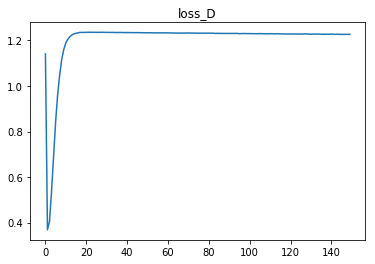

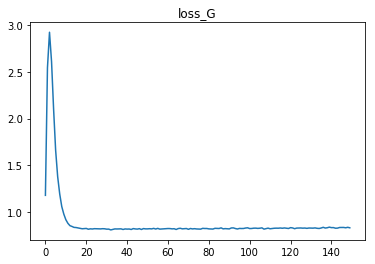

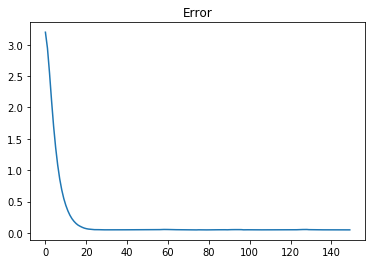

/home/wzhuai/.conda/envs/dl/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


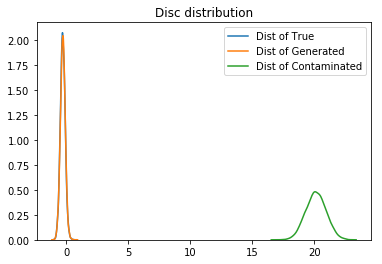

In [7]:
## A more detailed explanation for each argument can be founded in the code.

## Basic settings, dimension p=100, contamination ratio \epsilon=0.2, tol prevents \
## the denomenator being zero.
f = fgan(p=100, eps=0.2, device=device, tol=1e-5)
## Set the type of true distribution and contamination distribution. cont_mean and cont_var 
## give the parameter of contamination. A general contamination covariance matrix can be 
## provided by cont_covmat.
f.dist_init(true_type='Gaussian', cont_type='Gaussian', 
            cont_mean=5.0, cont_var=1.)
## Samples from Huber's contamination model.
f.data_init(train_size=50000, batch_size=500)
## Settings for Generator and Discriminator. d_hidden_units is a list of hidden units for 
## discriminator, e.g. d_hidden_units=[20] here means the discriminator has structure
## 100(input) - 20(hidden layer) - 1(output). Since (we assume that) we already know the type 
## of distribution is Gaussian, we directly model generator as G(z)=z+b, and elliptical=False.
## activation_D1 is the first activation function after input layer, others are set to be 
## 'LeakyReLU(0.2)' automatically.
f.net_init(d_hidden_units=[20], elliptical=False, activation_D1='LeakyReLU')
## Settings for optimizer. lr_d and lr_g are learning rate for discriminator and generator, 
## respectively. d_steps and g_steps are number of steps per iteration for discriminator and
## generator, respectively.
f.optimizer_init(lr_d=0.2, lr_g=0.02, d_steps=5, g_steps=1)
## floss is the type of f-GAN, and it can be set as 'js'(Jensen-Shannon GAN) and 'tv'(Total
## variation GAN). epochs gives the number of epochs for training. avg_epochs give the number
## of epochs for averaging. verbose and show are printing arguments.
f.fit(floss='js', epochs=150, avg_epochs=25, verbose=50, show=True)

`Cauchy Example:`

Samples are i.i.d drawn from $(1-\epsilon)\ Cauchy(0, I_p) + \epsilon\ Cauchy(5, I_p)$ with $\epsilon=0.2$, $p=100$ and $Cauchy(\mu, \Sigma)$ has density proportional to $p(x|\mu, \Sigma)\propto |\Sigma|^{-1/2}(1+(x-\mu)^T\Sigma^{-1}(x-\mu))^{-(1+p)/2}$. We estimate the center parameter $\mu=0$ by f-GAN. In this example, the Generator is setting as, $G(u, z)= g(z)u + b$ and $z=(z_1, 1/z_2)$ with $z_1, z_2\sim\mathcal{N}(0,I_{p/2})$ and g(z) is parameterized by a network. With enough expression power of $g(z)$, $G(u,z)$ can generate the family of elliptical distribution.

Initialize Mean Error: 2.5277
Epoch:50, LossD/G:1.2408/0.8121, Error(Mean):0.0781
Epoch:100, LossD/G:1.2365/0.8192, Error(Mean):0.0872
Epoch:150, LossD/G:1.2327/0.8241, Error(Mean):0.0739
Avg error: 0.0639, Last error: 0.0739


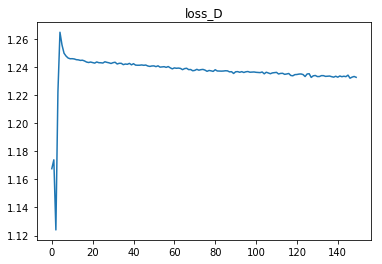

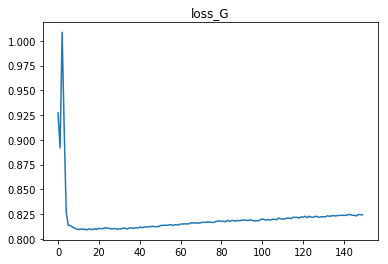

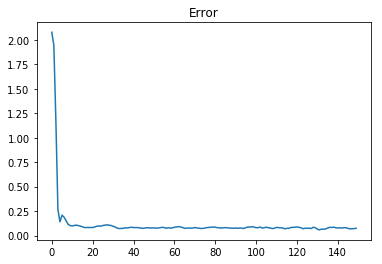

/home/wzhuai/.conda/envs/dl/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


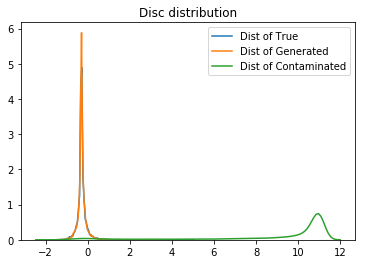

In [17]:
f = fgan(p=50, eps=0.2, device=device, tol=1e-5)
f.dist_init(true_type='Cauchy', cont_type='Cauchy', 
            cont_mean=5.0, cont_var=1.)
f.data_init(train_size=50000, batch_size=500)
f.net_init(d_hidden_units=[50, 25], g_hidden_units=[24, 24, 12, 12],
           g_input_dim=24, elliptical=True, activation_D1='Sigmoid')
f.optimizer_init(lr_d=0.1, lr_g=0.025, d_steps=1, g_steps=2)
f.fit(floss='js', epochs=150, avg_epochs=25, verbose=50, show=True)